In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold, train_test_split, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import re
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import time
import xgboost as xgb

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
train = pd.read_json('https://gitlab.com/abpaudel/cuisine/raw/master/cook_train.json')
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
train.iloc[0].ingredients

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

Text(0, 0.5, 'Count')

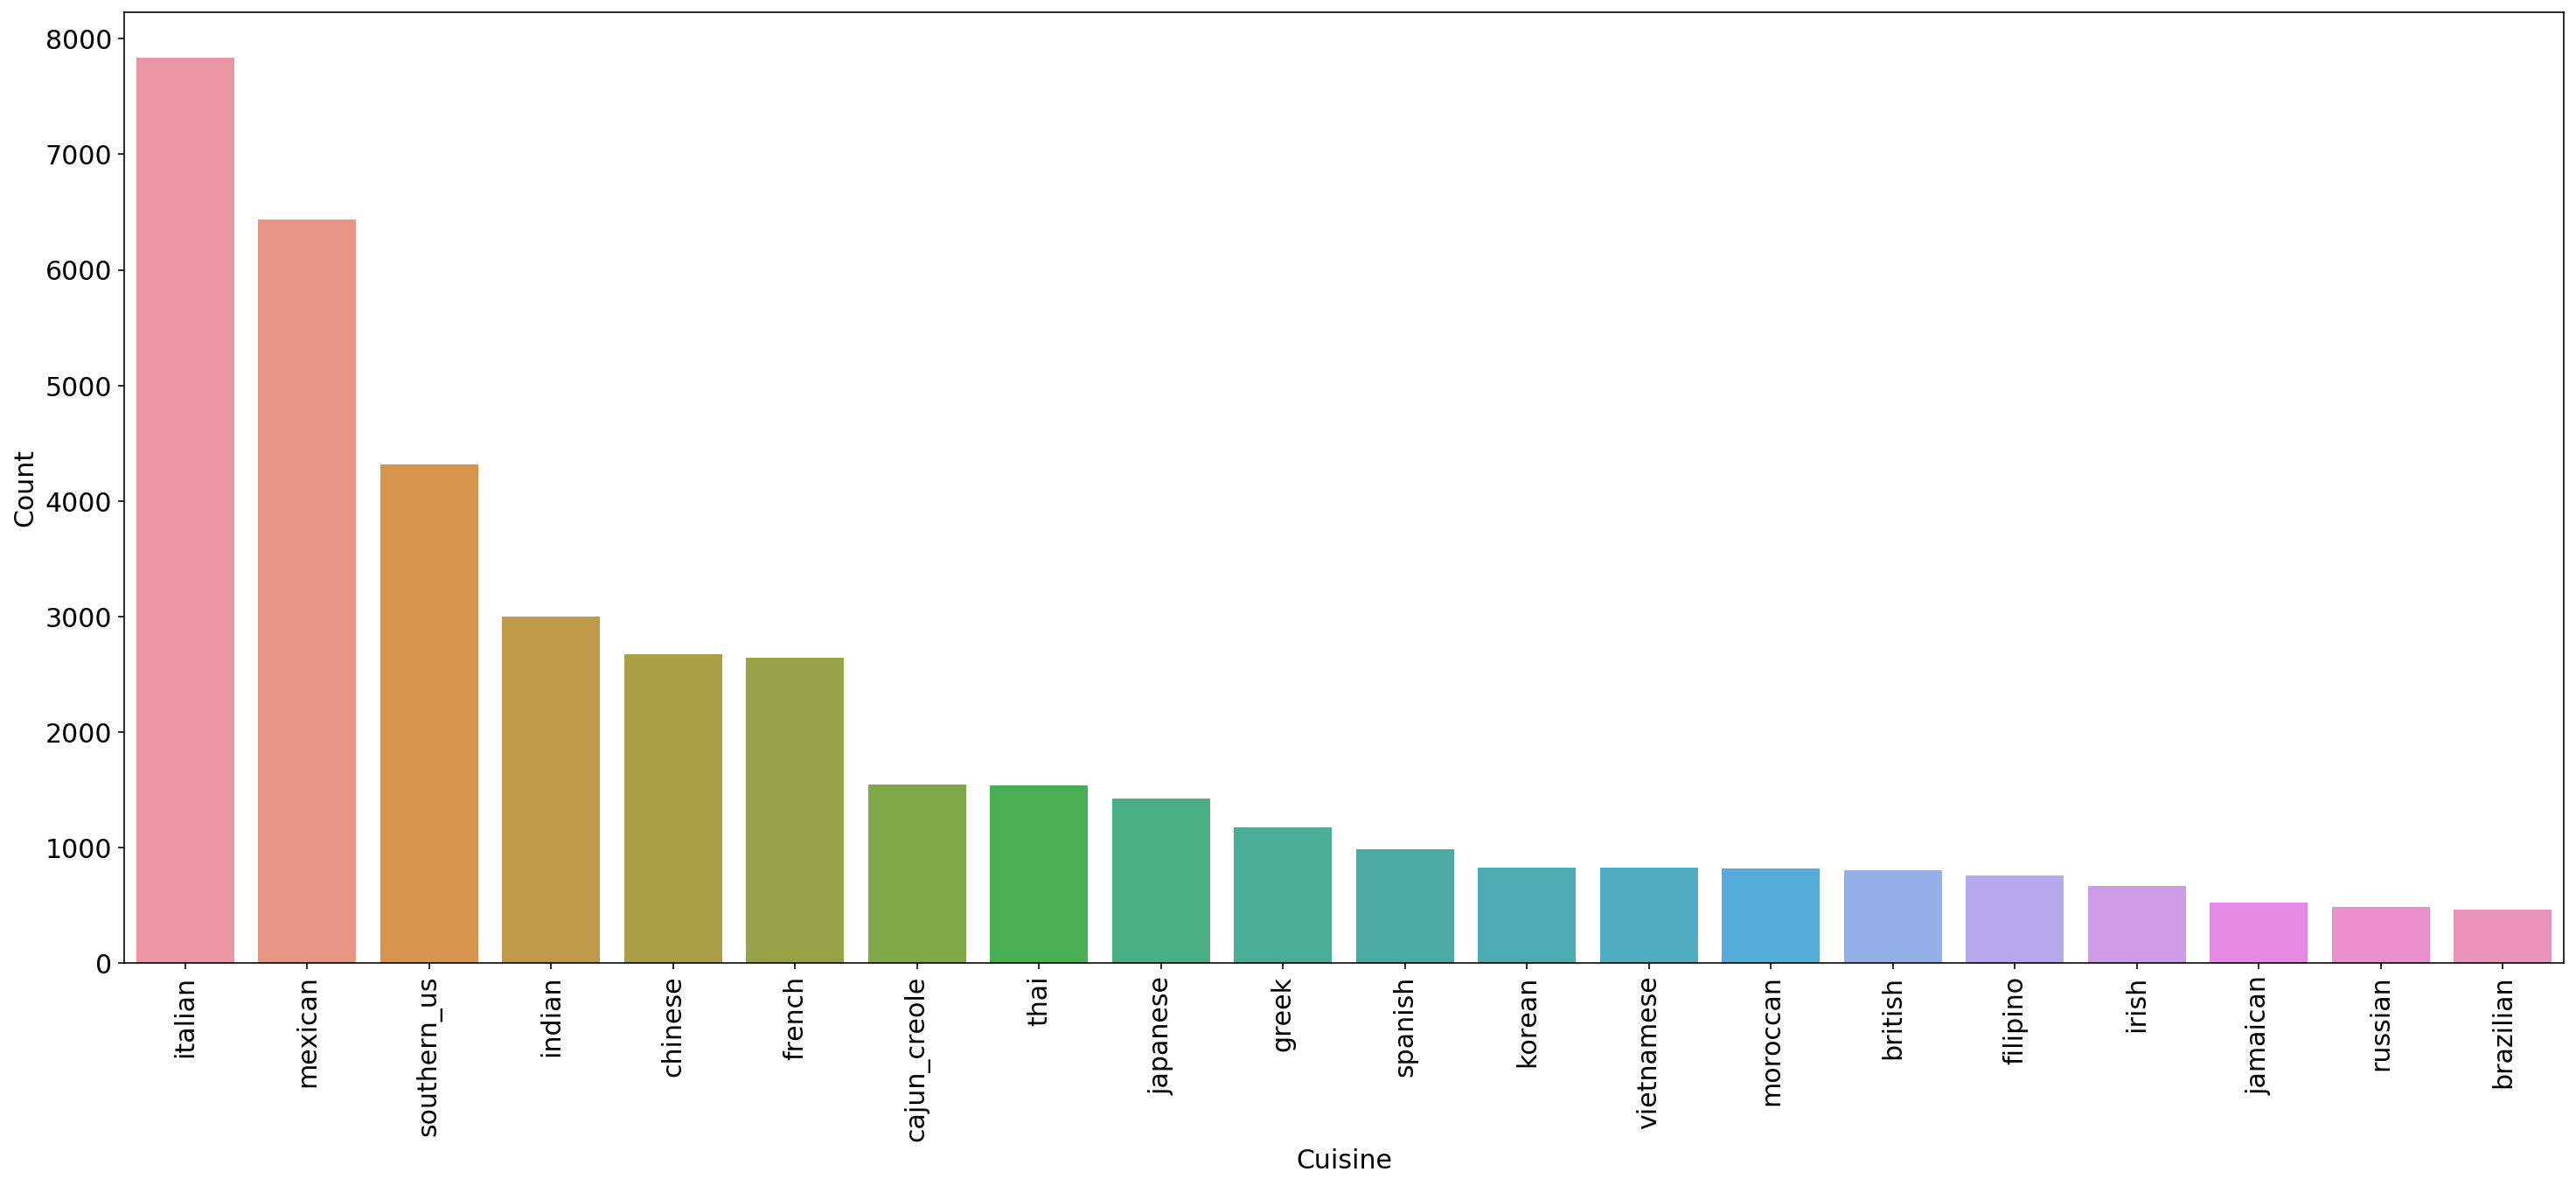

In [11]:
plt.figure(figsize=(25,10))
f = sns.countplot(train.cuisine,order=list(train.cuisine.value_counts().index))
f.set_xticklabels(f.get_xticklabels(), rotation=90)
f.tick_params(labelsize=15)
f.set_xlabel('Cuisine', fontsize=15)
f.set_ylabel('Count', fontsize=15)


In [12]:
# plt.figure(figsize=(15,10))
# train.cuisine.value_counts().plot.pie(autopct='%1.2f%%')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [14]:
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [10]:
','.join(train.iloc[0].ingredients)

'romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles'

In [18]:
# def preprocess(ingr):
#     ingr_text = ' '.join(ingr)
#     ingr_text = ingr_text.lower()
#     ingr_text = ingr_text.replace('-', ' ')
#     words = []
#     for word in ingr_text.split():
#         if re.findall('[0-9]', word): continue
#         if len(word) <= 2: continue
#         if len(word) > 0: words.append(word)
#     return ' '.join(words)
def preprocess(ingr):
    ingr_text = ' '.join(ingr)
    ingr_text = ingr_text.lower()
    ingr_text = ingr_text.replace('-', ' ')
    words = []
    for word in ingr_text.split():
        word = re.sub('[^a-zA-Z -]+', '', word)
        words.append(word.lower().strip(",.!:?;' "))
    return ' '.join(words)

In [19]:
train['ingredients_str'] = train.ingredients.apply(preprocess)
train.head()

,id,cuisine,ingredients,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


In [20]:
tfidf = TfidfVectorizer(max_features=2900)

In [21]:
X = tfidf.fit_transform(train.ingredients_str)
y = train.cuisine
X.shape

(39774, 2900)

In [22]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,stratify=y,test_size=0.3,random_state=0)

In [23]:
run = RandomUnderSampler(random_state=0)
Xun, yun = run.fit_resample(Xtrain,ytrain)
pd.Series(yun).value_counts()

irish           327
thai            327
moroccan        327
korean          327
indian          327
russian         327
cajun_creole    327
chinese         327
brazilian       327
mexican         327
spanish         327
vietnamese      327
japanese        327
italian         327
jamaican        327
french          327
southern_us     327
british         327
filipino        327
greek           327
dtype: int64

In [24]:
rov = RandomOverSampler(random_state=0)
Xov, yov = rov.fit_resample(Xtrain,ytrain)

In [25]:
Xun_pca = KernelPCA(n_components=500, kernel='linear').fit_transform(Xun)

In [26]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, random_state=0)
# kfold = KFold(n_splits=5, random_state=0)

In [27]:
model = MultinomialNB()
param_grid = {'alpha':[0.01]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X, y)
grid.best_params_

{'alpha': 0.01}

In [28]:
bayes = grid.best_estimator_
print('Train accuracy: {}'.format(bayes.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(bayes.score(Xtest, ytest)))

Train accuracy: 0.7819403038683955
Test accuracy: 0.775412721025727


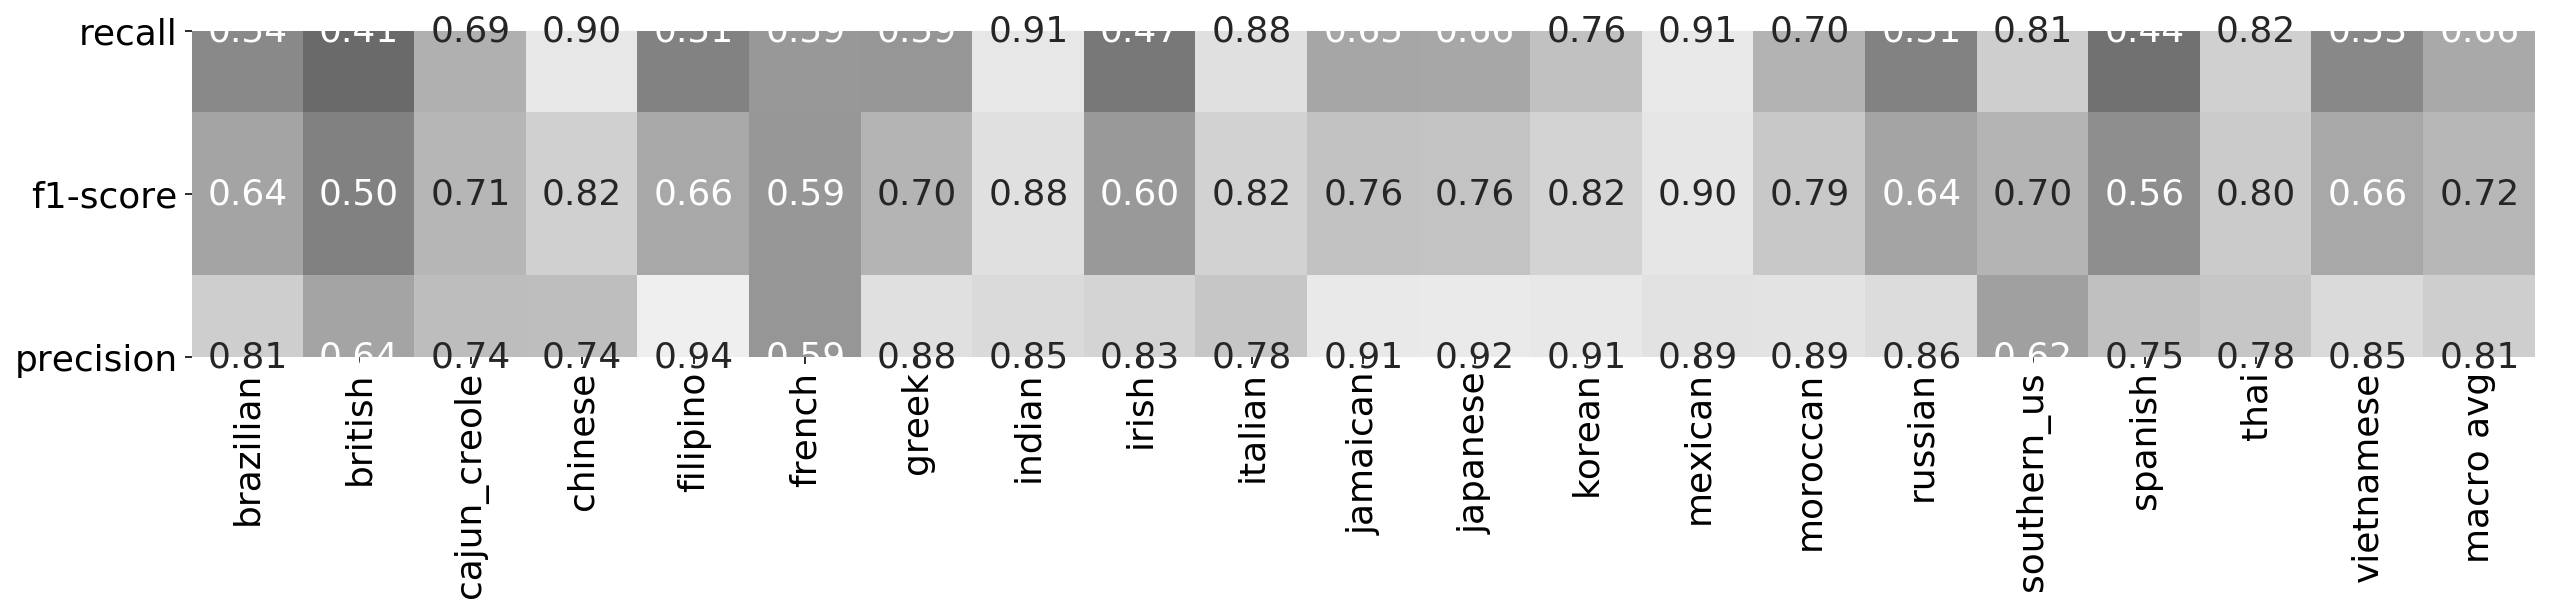

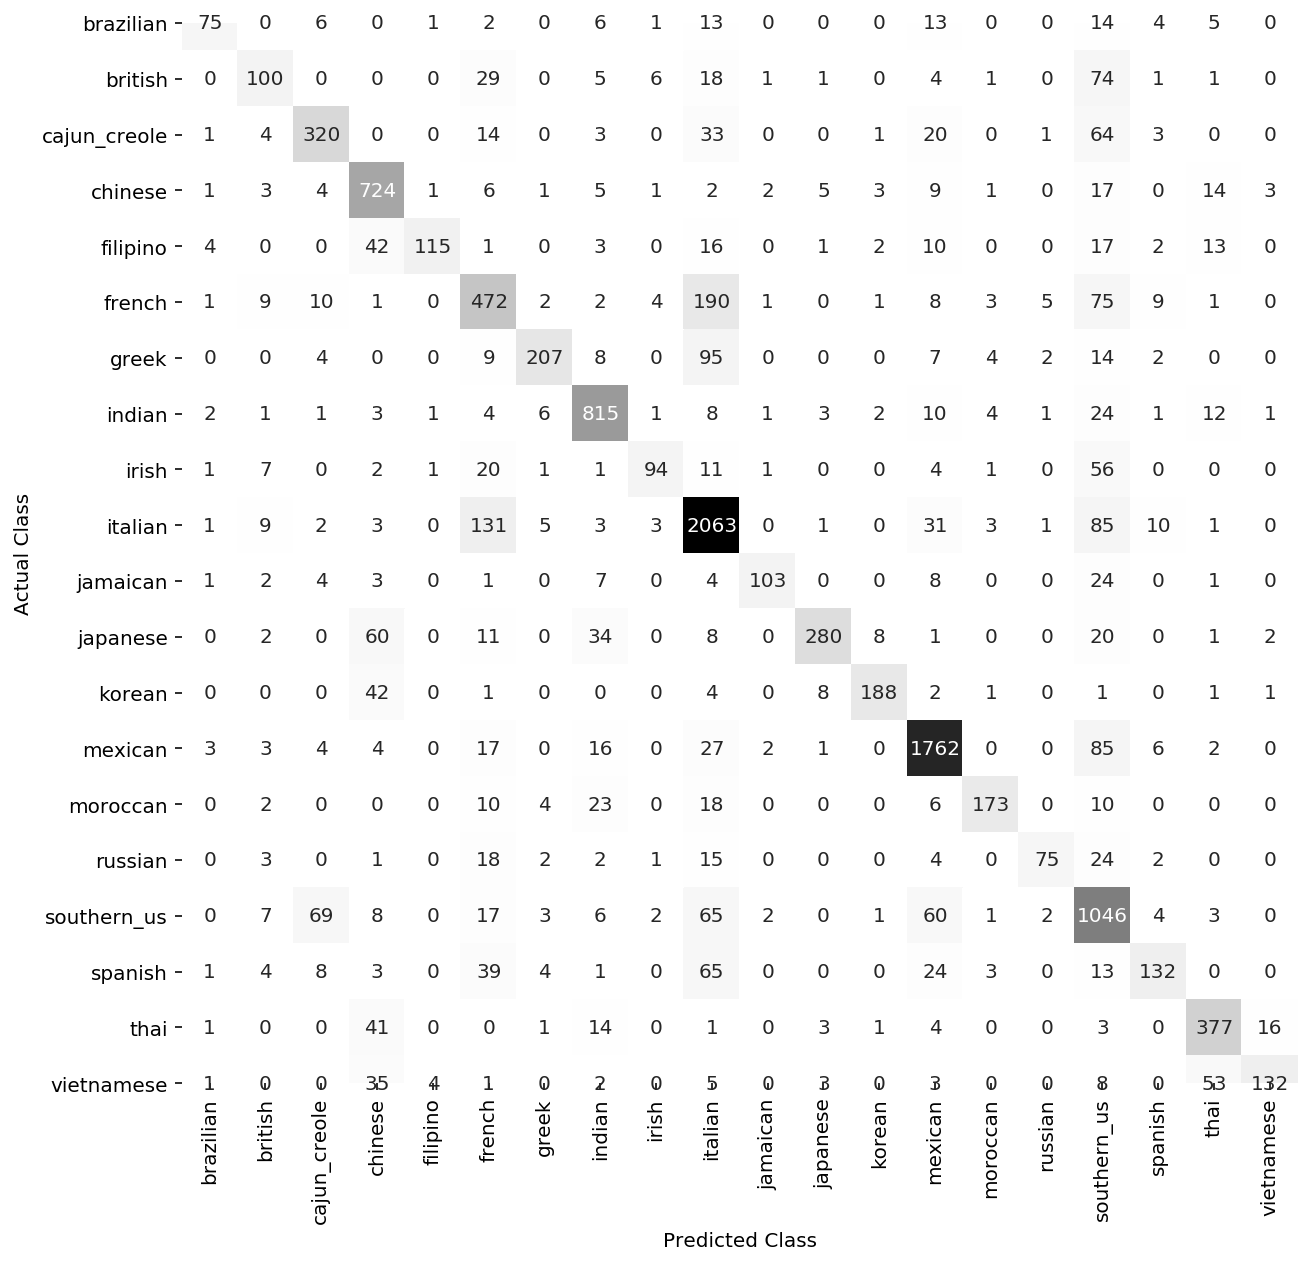

In [29]:
model = bayes
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [30]:
model = SVC(C=1, gamma=1)
# param_grid = {'tfidf__ngram_range':[(1,1)],'clf__C':[10], 'clf__gamma': [1]}

# grid = GridSearchCV(pipeline, param_grid, cv=5)

# grid.fit(Xtrain, ytrain)
# grid.score(Xtest, ytest)


model.fit(Xun_pca, ytrain)

ValueError: Found input variables with inconsistent numbers of samples: [6540, 27841]

In [ ]:
svm = model
print('Train accuracy: {}'.format(svm.score(Xun_pca, ytrain)))
print('Test accuracy: {}'.format(svm.score(Xtest, ytest)))

In [ ]:
model=svm
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy','macro avg', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier

def nn_model(input_dim):
  nn = Sequential()
  nn.add(Dense(50, input_dim=input_dim, activation='relu'))
  nn.add(Dense(50, activation='relu'))
  nn.add(Dense(20, activation='softmax'))
  nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return nn
# model = KerasClassifier(build_fn=nn_model, input_dim=500,epochs=10, batch_size=32, verbose=1)

# grid = GridSearchCV(pipeline, param_grid, cv=5)
# model.fit(Xtrain, ytrain)

In [ ]:
neural = model#grid.best_estimator_
print('Train accuracy: {}'.format(neural.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(neural.score(Xtest, ytest)))

In [ ]:
model=neural
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy','macro avg', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
trained_models = []
prf = []
dataset_list = [('Original Dataset',Xtrain,ytrain),
                ('Oversampled Dataset',Xov,yov),
                ('Undersampled Dataset',Xun,yun),
                ('Undersampled Dataset with PCA',Xun_pca,yun)]

for dataset,Xtrain,ytrain in dataset_list:
  print('-------------------------------------------------------------------------------------')
  print('Dataset:',dataset)
  print('-------------------------------------------------------------------------------------')
  models = []
  if dataset=='Undersampled Dataset with PCA':
    input_dim=500
    Xtest = KernelPCA(n_components=500, kernel='linear').fit_transform(Xtest)
  else:
    input_dim=2900
  model_list = [('Naive Bayes',MultinomialNB(alpha=0.001)),
              ('SVM',SVC(C=1, gamma=1)),
              ('Neural Network',KerasClassifier(build_fn=nn_model,input_dim=input_dim, epochs=10, batch_size=32, verbose=1))]
  for name, model in model_list:
    print('..............................')
    print('Classifier:',name)
    print('..............................')
    if dataset=='Undersampled Dataset with PCA' and name=='Naive Bayes':
      continue
    starttime = time.monotonic()
    model.fit(Xtrain,ytrain)
    print('Training time:',(time.monotonic()-starttime)/60, ' minutes')
    print('Train accuracy: {}'.format(model.score(Xtrain, ytrain)))
    print('Test accuracy: {}'.format(model.score(Xtest, ytest)))
    if dataset=='Original Dataset':
      y_pred = model.predict(Xtest)
      report=classification_report(ytest, y_pred, output_dict=True)
      prf.append(report)
    models.append(model)
  trained_models.append(models)



In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
import pickle

In [ ]:
with open('/drive/My Drive/trained_models.pkl', 'wb') as f:
     pickle.dump(trained_models, f)

In [ ]:
with open('/drive/My Drive/prf.pkl', 'wb') as f:
     pickle.dump(prf, f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(8,5))
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation Accuracy")

    plt.legend(loc="best")
    return plt


In [ ]:
model_list = [('Naive Bayes',MultinomialNB(alpha=0.001)),
              ('SVM',SVC(C=1, gamma=1)),
              ('Neural Network',KerasClassifier(build_fn=nn_model,input_dim=2900, epochs=10, batch_size=32, verbose=1))]

In [ ]:
title = "Learning Curves (Naive Bayes)"
cv = KFold(n_splits=5, random_state=0)

estimator = model_list[0][1]
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1), cv=cv, n_jobs=4)

plt.show()

In [ ]:
title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = KFold(n_splits=5, random_state=0)

estimator = model_list[1][1]
plot_learning_curve(estimator, title, X, y, (0.5, 1), cv=cv, n_jobs=4)

plt.show()

In [ ]:

title = "Learning Curves (ANN)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = KFold(n_splits=5, random_state=0)
estimator = model_list[2][1]
plot_learning_curve(estimator, title, X, y, (0.5, 1), cv=cv, n_jobs=4)

plt.show()

In [ ]:
model_list

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(Xtrain,ytrain)
print('Train accuracy: {}'.format(model.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(model.score(Xtest, ytest)))

In [ ]:
cv = KFold(n_splits=5, random_state=0)

estimator = model_list[0][1]
param_grid = {'alpha':[0.01]}
grid = GridSearchCV(estimator, param_grid, cv=cv)
grid.fit(X, y)
grid.best_params_

In [ ]:
estimator.fit(Xtrain,ytrain)
estimator.score(Xtrain, ytrain)

In [ ]:
estimator.score(Xtest,ytest)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost=AdaBoostClassifier(MultinomialNB(alpha=0.001), n_estimators=100, random_state=0)
adaboost.fit(Xtrain, ytrain)
adaboost.score(Xtest,ytest)

In [ ]:
adaboost.score(Xtrain, ytrain)

In [ ]:

dataset_list = [('Original Dataset',Xtrain,ytrain),
                ('Oversampled Dataset',Xov,yov),
                ('Undersampled Dataset',Xun,yun)]

for dataset,Xtrain,ytrain in dataset_list:
  print('-------------------------------------------------------------------------------------')
  print('Dataset:',dataset)
  print('-------------------------------------------------------------------------------------')
  for name, model in [('AdaBoost',AdaBoostClassifier(MultinomialNB(alpha=0.001), n_estimators=200, random_state=0))]:
      print('..............................')
      print('Classifier:',name)
      print('..............................')
      starttime = time.monotonic()
      model.fit(Xtrain,ytrain)
      print('Training time:',(time.monotonic()-starttime)/60, ' minutes')
      print('Train accuracy: {}'.format(model.score(Xtrain, ytrain)))
      print('Test accuracy: {}'.format(model.score(Xtest, ytest)))
      if dataset=='Original Dataset':
        y_pred = model.predict(Xtest)
        adaboost_prf=classification_report(ytest, y_pred, output_dict=True)


In [ ]:
import pickle
with open('/drive/My Drive/adaboost_prf.pkl', 'wb') as f:
     pickle.dump(adaboost_prf, f)